In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:

# Ordered roughly by accuracy
cases = ['DUP22q11_2','DEL15q11_2','DUP1q21_1','DEL1q21_1','DUP16p11_2','DEL16p11_2','DEL22q11_2','ADHD','ASD','SZ','BIP']

case_labels =       ['BIP                  n=44',
                    'SZ                   n=283',
                    'ASD                 n=472',
                    'ADHD              n=223',

                    'DEL 22q11.2     n=43',
                    'DEL 16p11.2      n=32',
                    
                    'DUP 16p11.2     n=35',
                    'DEL 1q21.1       n=25',
                    'DUP 1q21.1       n=19',
                    'DEL 15q11.2    n=103',
                    'DUP 22q11.2     n=22']
case_labels.reverse()

p_single = '../../results_reviews/baseline/shorter/'
p_mtl = '../../results_reviews/mtl/shorter/'

In [4]:
#############
# BASELINES #
#############

# ACCURACY:
# balanced baseline: 0.5
bip_base = 72
sz_base = 56
adhd_base = 61
baselines = pd.DataFrame([0.72,0.56,0.61], index = ['BIP','SZ','ADHD'], columns=['acc'])

# F1:
# balanced baseline: 0.6666
baselines['f1'] = 2*baselines['acc']/(baselines['acc'] + 1)
baselines

# AUC? leave at 0.5 for now?


acc        f1
BIP   0.72  0.837209
SZ    0.56  0.717949
ADHD  0.61  0.757764

# Load Data

In [5]:
# Single Task
st_data_conn = []
for case in cases:
    folds_conn = []
    for fold in range(5):
        # Connectomes
        p_parent = os.path.join(p_single, f"{case}/fold_{fold}")
        file = [f for f in os.listdir(p_parent) if f[-4:]=='.csv'][0]
        folds_conn.append(pd.read_csv(os.path.join(p_parent,file),index_col=0,header=[0,1])[case])

    st_data_conn.append(folds_conn)

st_data_conn = dict(zip(cases,st_data_conn))

In [6]:
# Multi-task
mtl_data_conn = []
for fold in range(5):
    # Connectomes
    p_parent = os.path.join(p_mtl, f"fold_{fold}")
    file = [f for f in os.listdir(p_parent) if f[-4:]=='.csv'][0]
    mtl_data_conn.append(pd.read_csv(os.path.join(p_parent,file),index_col=0,header=[0,1]))


# Get Scores

In [7]:
# Single Task
st_acc_conn = []
st_f1_conn = []
st_auc_conn = []
for case in cases:
    # Accuracy
    acc_vals = [st_data_conn[case][fold]['Accuracy/test'].iloc[-1] for fold in range(5)]
    st_acc_conn.append(acc_vals)

    # F1
    f1_vals = [st_data_conn[case][fold]['F1/test'].iloc[-1] for fold in range(5)]
    st_f1_conn.append(f1_vals)

    # AUC
    auc_vals = [st_data_conn[case][fold]['AUC/test'].iloc[-1] for fold in range(5)]
    st_auc_conn.append(auc_vals)


st_acc_conn = pd.DataFrame(st_acc_conn, index=cases)
st_acc_conn_mean = st_acc_conn.mean(axis=1)
st_acc_conn_std = st_acc_conn.std(axis=1)

st_f1_conn = pd.DataFrame(st_f1_conn, index=cases)
st_f1_conn_mean = st_f1_conn.mean(axis=1)
st_f1_conn_std = st_f1_conn.std(axis=1)

st_auc_conn = pd.DataFrame(st_auc_conn, index=cases)
st_auc_conn_mean = st_auc_conn.mean(axis=1)
st_auc_conn_std = st_auc_conn.std(axis=1)

In [8]:
# Multi-task
mtl_acc_conn = []
mtl_f1_conn = []
mtl_auc_conn = []
for fold in range(5):
    df = mtl_data_conn[fold].transpose().reset_index()

    # Accuracy
    mtl_acc_conn.append(df[df['level_1']=='Accuracy/test'].set_index('level_0')[99])

    # F1
    mtl_f1_conn.append(df[df['level_1']=='F1/test'].set_index('level_0')[99])

    # AUC
    mtl_auc_conn.append(df[df['level_1']=='AUC/test'].set_index('level_0')[99])

mtl_acc_conn = pd.concat(mtl_acc_conn,axis=1)
mtl_acc_conn_std = mtl_acc_conn.std(axis=1)
mtl_acc_conn_mean = mtl_acc_conn.mean(axis=1)

mtl_f1_conn = pd.concat(mtl_f1_conn,axis=1)
mtl_f1_conn_std = mtl_f1_conn.std(axis=1)
mtl_f1_conn_mean = mtl_f1_conn.mean(axis=1)

mtl_auc_conn = pd.concat(mtl_auc_conn,axis=1)
mtl_auc_conn_std = mtl_auc_conn.std(axis=1)
mtl_auc_conn_mean = mtl_auc_conn.mean(axis=1)

# Tables

In [9]:
# Connectomes
df_conn = pd.concat([st_acc_conn_mean,mtl_acc_conn_mean,st_acc_conn_std,mtl_acc_conn_std,
                     st_f1_conn_mean,mtl_f1_conn_mean,st_f1_conn_std,mtl_f1_conn_std,
                     st_auc_conn_mean,mtl_auc_conn_mean,st_auc_conn_std,mtl_auc_conn_std],axis=1)
df_conn.columns = ['ST_mean_acc','MTL_mean_acc','ST_std_acc','MTL_std_acc',
                   'ST_mean_f1','MTL_mean_f1','ST_std_f1','MTL_std_f1',
                   'ST_mean_auc','MTL_mean_auc','ST_std_auc','MTL_std_auc']
df_conn

ST_mean_acc  MTL_mean_acc  ST_std_acc  MTL_std_acc  ST_mean_f1  \
DUP22q11_2    38.888889     52.500000   11.111111    19.255030    0.400000   
DEL15q11_2    57.293844     52.950058    6.690339     7.664229    0.454709   
DUP1q21_1     58.571429     60.357143   21.219215    20.570623    0.516667   
DEL1q21_1     68.000000     64.000000   16.431677    18.165902    0.672222   
DUP16p11_2    67.142857     72.857143    8.144110     5.976143    0.527857   
DEL16p11_2    73.333333     75.128205   11.971915     9.746963    0.721775   
DEL22q11_2    84.967320     82.614379   11.244870    12.337196    0.635368   
ADHD          56.242879     52.938531    3.277219     5.350287    0.367327   
ASD           63.099178     62.041540    3.082111     2.621347    0.605115   
SZ            76.342274     75.707431    3.257386     2.249189    0.677312   
BIP           77.721774     79.032258    3.045957     9.088528    0.404762   

            MTL_mean_f1  ST_std_f1  MTL_std_f1  ST_mean_auc  MTL_mean_auc  \
DUP22q11_2     0.345476   0.317688    0.304062     0.472083      0.527500   
DEL15q11_2     0.354372   0.058652    0.123386     0.561667      0.549444   
DUP1q21_1      0.603810   0.302765    0.192088     0.686667      0.730000   
DEL1q21_1      0.599242   0.270059    0.273521     0.739583      0.570000   
DUP16p11_2     0.661905   0.236536    0.122289     0.811667      0.805893   
DEL16p11_2     0.719351   0.100399    0.192310     0.865000      0.833333   
DEL22q11_2     0.654680   0.161543    0.247594     0.755754      0.806944   
ADHD           0.408307   0.095138    0.087725     0.502516      0.538127   
ASD            0.600107   0.049953    0.074422     0.679593      0.679846   
SZ             0.691650   0.053751    0.054673     0.823743      0.817604   
BIP            0.635833   0.100251    0.034205     0.789762      0.818125   

            ST_std_auc  MTL_std_auc  
DUP22q11_2    0.129314     0.147125  
DEL15q11_2    0.077640     0.049677  
DUP1q21_1     0.266250     0.315436  
DEL1q21_1     0.272734     0.103682  
DUP16p11_2    0.070119     0.118211  
DEL16p11_2    0.110930     0.178341  
DEL22q11_2    0.118668     0.097786  
ADHD          0.061254     0.045685  
ASD           0.034864     0.057244  
SZ            0.043204     0.041774  
BIP           0.083966     0.024380

In [10]:
df_conn.mean()

ST_mean_acc     65.600343
MTL_mean_acc    66.375153
ST_std_acc       9.043265
MTL_std_acc     10.275040
ST_mean_f1       0.543919
MTL_mean_f1      0.570430
ST_std_f1        0.158794
MTL_std_f1       0.155116
ST_mean_auc      0.698912
MTL_mean_auc     0.697892
ST_std_auc       0.115358
MTL_std_auc      0.107213
dtype: float64

# Plots

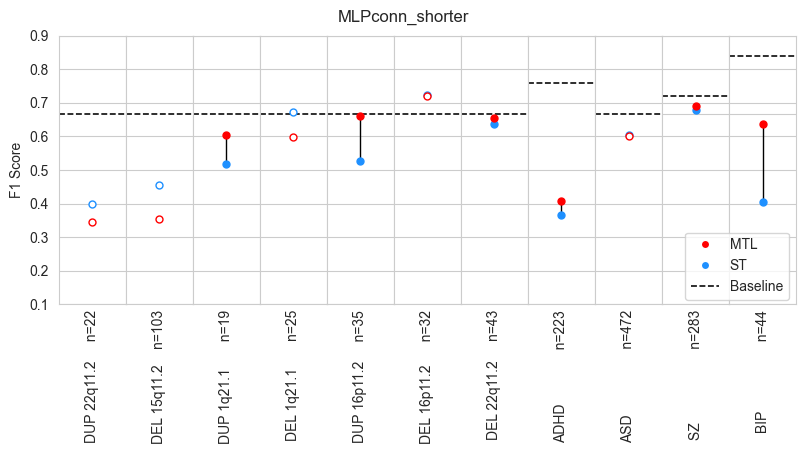

In [12]:
######
# F1 #
######
title = 'MLPconn_shorter'
fig,ax = plt.subplots(1,len(cases),figsize=(8,4.5),sharey=True,sharex=True)
# BIP 0.84
# SZ 0.72
# ADHD 0.76
plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.666,0.7,0.72,0.76,0.8,0.84,0.9],
           labels=[0.1,0.2,0.3,0.4,0.5,0.6,None,0.7,None,None,0.8,None,0.9])
sns.set_style('whitegrid')
colors = ['black','darkorchid','red','orange','dodgerblue','forestgreen']

for j,case in enumerate(cases):
    st_mean_f1 = df_conn.loc[case]['ST_mean_f1']
    mtl_mean_f1 = df_conn.loc[case]['MTL_mean_f1']
    if st_mean_f1 > mtl_mean_f1:
        mfc_mtl = 'white'
        mfc_st = 'white'
        ls =''
    else:
        mfc_mtl = colors[2]
        mfc_st = colors[-2]
        ls = '-'

    ax[j].plot((5,5),(st_mean_f1,mtl_mean_f1),color=colors[0],ls=ls,linewidth=1)
    ax[j].plot(5,st_mean_f1,marker='o',color=colors[-2],ms=5,markerfacecolor=mfc_st)
    ax[j].plot(5,mtl_mean_f1,marker='o',color=colors[2],ms=5,markerfacecolor=mfc_mtl)
    ax[j].set_xticklabels([])
    ax[j].set_xticks([])
    ax[j].set_xlabel(case_labels[j],rotation=90)

    lines = ax[j].get_ygridlines()
    if case not in ['ADHD','BIP','SZ']:
        b = lines[6]
        b.set_color('black')
        b.set_linewidth(1.15)
        b.set_linestyle('--')

        w1 = lines[11] # BIP
        w1.set_color('white')
        w1.set_linewidth(1.15)
        w1.set_linestyle('-')

        w2 = lines[9] # ADHD
        w2.set_color('white')
        w2.set_linewidth(1.15)
        w2.set_linestyle('-')

        w2 = lines[8] # SZ
        w2.set_color('white')
        w2.set_linewidth(1.15)
        w2.set_linestyle('-')
    if case == 'ADHD':
        b = lines[6]
        b.set_color('white')
        b.set_linewidth(1.15)
        b.set_linestyle('-')

        w1 = lines[11] # BIP
        w1.set_color('white')
        w1.set_linewidth(1.15)
        w1.set_linestyle('-')

        w2 = lines[9] # ADHD
        w2.set_color('black')
        w2.set_linewidth(1.15)
        w2.set_linestyle('--')

        w2 = lines[8] # SZ
        w2.set_color('white')
        w2.set_linewidth(1.15)
        w2.set_linestyle('-')

    if case == 'SZ':
        w1 = lines[11] # BIP
        w1.set_color('white')
        w1.set_linewidth(1.15)
        w1.set_linestyle('-')

        w2 = lines[9] # ADHD
        w2.set_color('white')
        w2.set_linewidth(1.15)
        w2.set_linestyle('-')

        w2 = lines[8] # SZ
        w2.set_color('black')
        w2.set_linewidth(1.15)
        w2.set_linestyle('--')
    if case == 'BIP':
        w1 = lines[11] # BIP
        w1.set_color('black')
        w1.set_linewidth(1.15)
        w1.set_linestyle('--')

        w2 = lines[9] # ADHD
        w2.set_color('white')
        w2.set_linewidth(1.15)
        w2.set_linestyle('-')

        w2 = lines[8] # SZ
        w2.set_color('white')
        w2.set_linewidth(1.15)
        w2.set_linestyle('-')
    

    
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], marker='o',color='w', label='MTL',
                          markerfacecolor=colors[2]),
        Line2D([0], [0], marker='o', color='w', label='ST',
                          markerfacecolor=colors[-2]),
        Line2D([0], [0], color='black', label='Baseline',
                           linewidth=1.15,ls='--')
                          ]
labels = ['MTL','ST','Baseline']
fig.legend(handles, labels, loc=(0.85,0.34))

ax[0].set_ylabel('F1 Score')
plt.suptitle(title)
plt.ylim(0.1,0.9)
plt.tight_layout(pad=0.5)
plt.subplots_adjust(wspace=0)
plt.savefig(os.path.join('./figures/conditions_f1_shorter.png'),dpi=300)

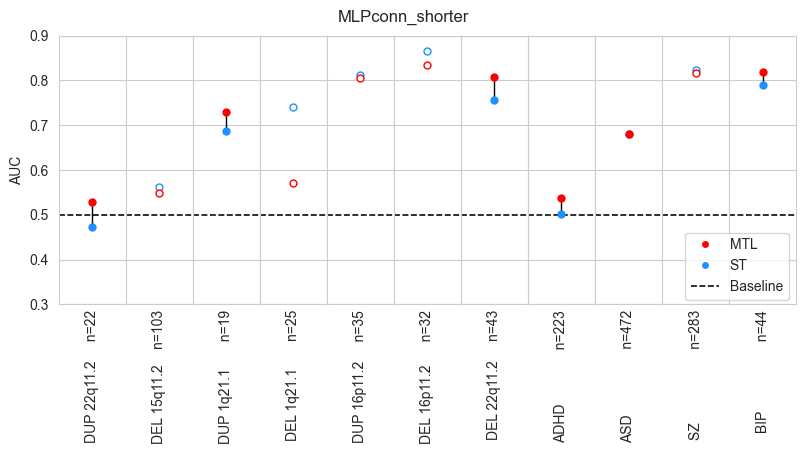

In [13]:
######
# AUC #
######
title = 'MLPconn_shorter'
fig,ax = plt.subplots(1,len(cases),figsize=(8,4.5),sharey=True,sharex=True)
plt.yticks([0.3,0.4,0.5,0.6,0.7,0.8,0.9])
sns.set_style('whitegrid')
colors = ['black','darkorchid','red','orange','dodgerblue','forestgreen']

for j,case in enumerate(cases):
    st_mean_auc = df_conn.loc[case]['ST_mean_auc']
    mtl_mean_auc = df_conn.loc[case]['MTL_mean_auc']
    if st_mean_auc > mtl_mean_auc:
        mfc_mtl = 'white'
        mfc_st = 'white'
        ls =''
    else:
        mfc_mtl = colors[2]
        mfc_st = colors[-2]
        ls = '-'

    ax[j].plot((5,5),(st_mean_auc,mtl_mean_auc),color=colors[0],ls=ls,linewidth=1)
    ax[j].plot(5,st_mean_auc,marker='o',color=colors[-2],ms=5,markerfacecolor=mfc_st)
    ax[j].plot(5,mtl_mean_auc,marker='o',color=colors[2],ms=5,markerfacecolor=mfc_mtl)
    ax[j].set_xticklabels([])
    ax[j].set_xticks([])
    ax[j].set_xlabel(case_labels[j],rotation=90)

    lines = ax[j].get_ygridlines()
    b = lines[2]
    b.set_color('black')
    b.set_linewidth(1.15)
    b.set_linestyle('--')
    

    
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], marker='o',color='w', label='MTL',
                          markerfacecolor=colors[2]),
        Line2D([0], [0], marker='o', color='w', label='ST',
                          markerfacecolor=colors[-2]),
        Line2D([0], [0], color='black', label='Baseline',
                           linewidth=1.15,ls='--'),
                          ]
labels = ['MTL','ST','Baseline']
fig.legend(handles, labels, loc=(0.85,0.34))

ax[0].set_ylabel('AUC')
plt.suptitle(title)
plt.ylim(0.3,0.9)
plt.tight_layout(pad=0.5)
plt.subplots_adjust(wspace=0)
plt.savefig(os.path.join('./figures/conditions_auc_shorter.png'),dpi=300)

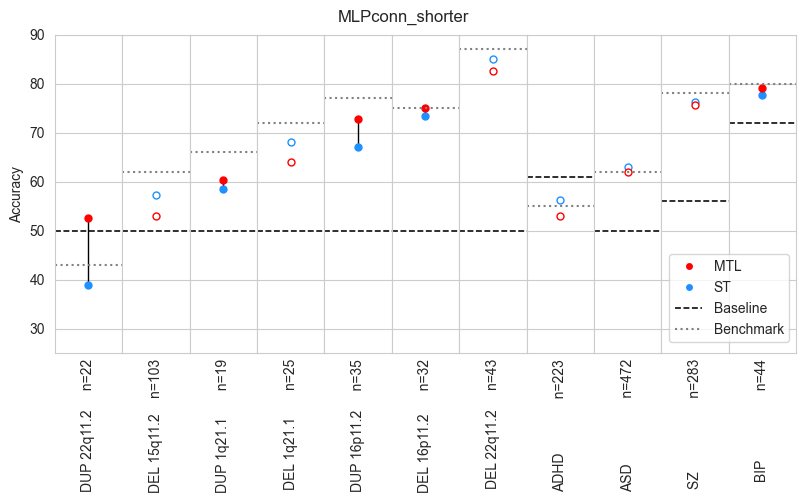

In [14]:
#########################
# ADJUSTED CHANCE LEVEL #
#########################
title = 'MLPconn_shorter'
fig,ax = plt.subplots(1,len(cases),figsize=(8,5),sharey=True,sharex=True)
#plt.yticks([40,50,60,70,80,90])
# BIP: 100 - 28 = 72
# SZ: 100 - 44 = 56
# ADHD: 100 - 39 = 61
plt.yticks([30,40,50,56,60,61,70,72,80,90],
           labels = [30,40,50,None,60,None,70,None,80,90])
sns.set_style('whitegrid')
colors = ['black','darkorchid','red','orange','dodgerblue','forestgreen']

for j,case in enumerate(cases):
    st_acc = df_conn.loc[case]['ST_mean_acc']
    mtl_acc = df_conn.loc[case]['MTL_mean_acc']
    if st_acc > mtl_acc:
        mfc_mtl = 'white'
        mfc_st = 'white'
        ls =''
    else:
        mfc_mtl = colors[2]
        mfc_st = colors[-2]
        ls = '-'

    ax[j].plot((5,5),(st_acc,mtl_acc),color=colors[0],ls=ls,linewidth=1)
    ax[j].plot(5,st_acc,marker='o',color=colors[-2],ms=5,markerfacecolor=mfc_st)
    ax[j].plot(5,mtl_acc,marker='o',color=colors[2],ms=5,markerfacecolor=mfc_mtl)
    ax[j].set_xticklabels([])
    ax[j].set_xticks([])
    ax[j].set_xlabel(case_labels[j],rotation=90)

    if case == 'DUP22q11_2':
        ax[j].axhline(y=43, color='gray', linestyle='dotted',linewidth=1.5)
    if case == 'DEL15q11_2':
        ax[j].axhline(y=62, color='gray', linestyle='dotted',linewidth=1.5)
    if case == 'DUP1q21_1':
        ax[j].axhline(y=66, color='gray', linestyle='dotted',linewidth=1.5)
    if case == 'DEL1q21_1':
        ax[j].axhline(y=72, color='gray', linestyle='dotted',linewidth=1.5)
    if case == 'DUP16p11_2':
        ax[j].axhline(y=77, color='gray', linestyle='dotted',linewidth=1.5)
    if case == 'DEL16p11_2':
        ax[j].axhline(y=75, color='gray', linestyle='dotted',linewidth=1.5)
    if case == 'DEL22q11_2':
        ax[j].axhline(y=87, color='gray', linestyle='dotted',linewidth=1.5)
    if case == 'ADHD':
        ax[j].axhline(y=55, color='gray', linestyle='dotted',linewidth=1.5)
    if case == 'ASD':
        ax[j].axhline(y=62, color='gray', linestyle='dotted',linewidth=1.5)
    if case == 'SZ':
        ax[j].axhline(y=78, color='gray', linestyle='dotted',linewidth=1.5)
    if case == 'BIP':
        ax[j].axhline(y=80, color='gray', linestyle='dotted',linewidth=1.5)

    lines = ax[j].get_ygridlines()
    if case not in ['ADHD','BIP','SZ']:
        b = lines[2]
        b.set_color('black')
        b.set_linewidth(1.15)
        b.set_linestyle('--')

        w1 = lines[7] # BIP
        w1.set_color('white')
        w1.set_linewidth(1.15)
        w1.set_linestyle('-')

        w2 = lines[5] # ADHD
        w2.set_color('white')
        w2.set_linewidth(1.15)
        w2.set_linestyle('-')

        w2 = lines[3] # SZ
        w2.set_color('white')
        w2.set_linewidth(1.15)
        w2.set_linestyle('-')
    if case == 'ADHD':
        w1 = lines[7] # BIP
        w1.set_color('white')
        w1.set_linewidth(1.15)
        w1.set_linestyle('-')

        w2 = lines[5] # ADHD
        w2.set_color('black')
        w2.set_linewidth(1.15)
        w2.set_linestyle('--')

        w2 = lines[3] # SZ
        w2.set_color('white')
        w2.set_linewidth(1.15)
        w2.set_linestyle('-')
    if case == 'SZ':
        w1 = lines[7] # BIP
        w1.set_color('white')
        w1.set_linewidth(1.15)
        w1.set_linestyle('-')

        w2 = lines[5] # ADHD
        w2.set_color('white')
        w2.set_linewidth(1.15)
        w2.set_linestyle('-')

        w2 = lines[3] # SZ
        w2.set_color('black')
        w2.set_linewidth(1.15)
        w2.set_linestyle('--')

    if case == 'BIP':
        w1 = lines[7] # BIP
        w1.set_color('black')
        w1.set_linewidth(1.15)
        w1.set_linestyle('--')

        w2 = lines[5] # ADHD
        w2.set_color('white')
        w2.set_linewidth(1.15)
        w2.set_linestyle('-')

        w2 = lines[3] # SZ
        w2.set_color('white')
        w2.set_linewidth(1.15)
        w2.set_linestyle('-')

from matplotlib.lines import Line2D
handles = [Line2D([0], [0], marker='o',color='w', label='MTL',
                          markerfacecolor=colors[2]),
        Line2D([0], [0], marker='o', color='w', label='ST',
                          markerfacecolor=colors[-2]),
        Line2D([0], [0], color='black', label='Baseline',
                           linewidth=1.15,ls='--'),
        Line2D([0], [0], color='grey', label='Benchmark',
                           linewidth=1.5,ls='dotted')
                          ]
labels = ['MTL','ST','Baseline', 'Benchmark']
fig.legend(handles, labels, loc=(0.83,0.32))

ax[0].set_ylabel('Accuracy')
plt.suptitle(title)
plt.ylim(25,90)
plt.tight_layout(pad=0.5)
plt.subplots_adjust(wspace=0)
plt.savefig(os.path.join('./figures/conditions_acc_shorter.png'),dpi=300)